In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import math

SCORE_TRESHOLD = 0.5
EXPANSION_FACTOR = 0.01
BINARY_IMAGE_TRESHOLD = 160
CANNY_LOW_TRESHOLD = 180
CANNY_HIGH_TRESHOLD = 200
WHEEL_TEMPLATE = cv2.imread("/content/drive/My Drive/IACV/wheel_template.png")[:,:,0]

def convert_bb_to_opencv(bb, frame):
    """
    Convert YOLO bounding box format (x_center, y_center, width, height)
    to OpenCV format (start, end).
    """
    img_height, img_width = frame.shape[:2]
    x_center, y_center, width, height = bb

    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x_min = int(x_center - width / 2)
    y_min = int(y_center - height / 2)
    x_max = int(x_center + width / 2)
    y_max = int(y_center + height / 2)

    start = (x_min, y_min)
    end = (x_max, y_max)

    return start, end


def convert_bbox_to_xywh(bbox, frame):
    """
    Convert YOLO bounding box format to OpenCV format (x, y, width, height).
    """
    start, end = convert_bb_to_opencv(bbox, frame)
    x = start[0]
    y = start[1]
    width = end[0] - start[0]
    height = end[1] - start[1]

    return (x, y, width, height)

def add_bbox_to_frame(detection, frame):
  s, e = convert_bb_to_opencv(detection, frame)
  new_frame =  cv2.rectangle(frame, s, e, (0, 255, 0), 2)
  return new_frame

def add_boxes_to_frame(boxes, frame):
    for bbox in boxes:
      frame = add_bbox_to_frame(bbox, frame)

    return frame

def detect_wheels_ellipses(boxes, image):
  best_matches = []
  for box in boxes:
    x, y, w, h = convert_bbox_to_xywh(box, image)
    bbc_x, bbc_y = x+(w // 2), y+(h // 2)
    patch = image[y:y+h, x:x+w]

    gray_image = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.equalizeHist(gray_image)
    _, binary_image = cv2.threshold(gray_image, BINARY_IMAGE_TRESHOLD, 255, cv2.THRESH_BINARY)
    binary_image = cv2.medianBlur(binary_image, ksize=5)

    edges = cv2.Canny(binary_image, CANNY_LOW_TRESHOLD, CANNY_HIGH_TRESHOLD)
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    #input_height, input_width = gray_image.shape[:2]
    #template = cv2.resize(WHEEL_TEMPLATE, (input_width, input_height), interpolation=cv2.INTER_AREA)

    best_match_val = None
    best_match_ellipse = None
    for c in contours:
      if(len(c) < 5): continue
      ellipse = cv2.fitEllipse(c)
      (center, axes, angle) = ellipse

      if not math.isnan(center[0]) and not math.isnan(center[1]):
        new_center = (int(center[0] + x), int(center[1] + y))
        new_ellipse = (new_center, axes, angle)

        e_w, e_h = axes
        if(e_w < w / 2 or e_h < h / 2):
          continue

        ellipse_points = cv2.ellipse2Poly(new_center, (int(e_w/2), int(e_h/2)), int(angle), 0, 360, 10)

        if(not all(x <= point[0] <= x+w and y <= point[1] <= y+h for point in ellipse_points)):
          continue

        ellipse_mask = np.zeros_like(gray_image)
        cv2.ellipse(ellipse_mask, ellipse, (255, 255, 255), -1)
        ellipse_roi = cv2.bitwise_and(binary_image, ellipse_mask)

        '''
        result = cv2.matchTemplate(ellipse_roi, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)

        if(best_match_val == None or max_val > best_match_val):
          best_match_dist = max_val
          best_match_ellipse = new_ellipse
        '''

        dist = math.sqrt((bbc_x - new_center[0])**2 + (bbc_y - new_center[1])**2)

        if(best_match_val == None or dist > best_match_val):
            best_match_dist = dist
            best_match_ellipse = new_ellipse

    if(best_match_ellipse == None): continue
    best_matches.append(best_match_ellipse)
    image = cv2.ellipse(image, best_match_ellipse, (0, 255, 0), 2)
    image = cv2.circle(image, (bbc_x, bbc_y), 5, (255, 0, 255), -1)
  return image, best_matches

def detect_features_points(ellipses, frame):
  points = []
  for ellipse in ellipses:
    (center, axes, angle) = ellipse
    e_w, e_h = axes
    ellipse_points = cv2.ellipse2Poly(center, (int(e_w/2), int(e_h/2)), int(angle), 0, 360, 10)
    p1 = max(ellipse_points, key=lambda point: point[1]) # CONTACT POINT
    p2 = min(ellipse_points, key=lambda point: point[1]) # TOP POINT
    p3 = (min(ellipse_points, key=lambda point: point[0])[0], (abs(p1[1] - p2[1])//2) + p2[1]) # LEFT
    p4 = (max(ellipse_points, key=lambda point: point[0])[0], (abs(p1[1] - p2[1])//2) + p2[1]) # RIGHT
    points.append([p1,p2,p3,p4])

    frame = cv2.circle(frame, (p1[0], p1[1]), 5, (0, 0, 255), -1)
    frame = cv2.circle(frame, (p2[0], p2[1]), 5, (0, 0, 255), -1)
    frame = cv2.circle(frame, (p3[0], p3[1]), 5, (0, 0, 255), -1)
    frame = cv2.circle(frame, (p4[0], p4[1]), 5, (0, 0, 255), -1)

  return frame, points

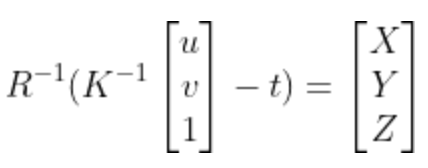





In [ ]:
WHEEL_RADIUS = 20
WHEELS_MODEL = np.array([(0,WHEEL_RADIUS,0),(0,-WHEEL_RADIUS,0),(-WHEEL_RADIUS,0,0),(WHEEL_RADIUS,0,0)], dtype='float32')

def compute_camera_pose(pts, pts3d, K, d):
  return cv2.solvePnP(pts3d, pts, K, d)

def image_to_word(pt, K, rvec, tvec):
  R, _ = cv2.Rodrigues(rvec)
  return np.dot(np.linalg.inv(R),((np.dot(np.linalg.inv(K), np.vstack((pt,np.array([[1]]))))) - tvec))

In [ ]:
from tqdm import tqdm
import pandas as pd
import pickle
import plotly.graph_objects as go
import os
from PIL import Image

video_path = '/content/drive/My Drive/IACV/Videos/video_straight_hill_frames'
text_directory = '/content/drive/My Drive/IACV/Videos/video_straight_hill_bbs'

files = os.listdir(video_path)
jpg_files = [file for file in files if file.lower().endswith('.jpg')]
jpg_files = sorted(jpg_files)

progress_bar = tqdm(total = len(jpg_files), desc='Video processing progress', position=0, leave=True)

output_video_path = '/content/drive/My Drive/IACV/Processed_videos/yolov5_Geometric_video_straight_hill.mp4'
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (1920, 1080))

f = open("/content/drive/My Drive/IACV/calibration/cameraMatrix.pkl", 'rb')
data = pickle.load(f)
K = np.array(data)
f.close()

f = open('/content/drive/My Drive/IACV/calibration/dist.pkl', 'rb')
data = pickle.load(f)
d = np.array(data).reshape(-1)
f.close()

world_points = []
index = 0
errors = []
while index < len(jpg_files):

    image_path = os.path.join(video_path, jpg_files[index])
    img = Image.open(image_path)
    namefile = jpg_files[index]

    text_file_name = namefile.replace("jpg", "txt")
    text_path = os.path.join(text_directory, text_file_name)
    if os.path.exists(text_path):
      files = open(text_path, 'r')

      bounding_boxes = []
      for line in files:
          parts = line.strip().split()
          if len(parts) == 5:
              bounding_box = list(map(float, parts[1:]))
              bounding_boxes.append(bounding_box)
      img = np.array(img)
      processed_frame = add_boxes_to_frame(bounding_boxes, img)
      image_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
      processed_frame, ellipses = detect_wheels_ellipses(bounding_boxes, image_rgb)
      processed_frame, feature_points = detect_features_points(ellipses, processed_frame)

      if(len(feature_points) >= 1): # if there is at least 1 ellipse detected
        success, rvec, tvec = compute_camera_pose(np.array(feature_points[0]).astype('float32'), WHEELS_MODEL, K, d)
        world_points.append(image_to_word(np.array([feature_points[0][0]]).T, K, rvec, tvec).reshape(-1))

        projected_image_points, _ = cv2.projectPoints(WHEELS_MODEL, rvec, tvec, K, d)
        error = cv2.norm(np.array(feature_points[0]).astype('float32'), projected_image_points.reshape(-1, 2), cv2.NORM_L2) / len(projected_image_points)
        errors.append(error)

        if(len(feature_points) == 2): # if there is another ellipse back-project the contact point
          #world_points.append((np.dot(R.reshape(-1), np.append(feature_points[1][0],1)) + t).reshape(-1))
          world_points.append(image_to_word(np.array([feature_points[1][0]]).T, K, rvec, tvec).reshape(-1))
      out.write(processed_frame)

    progress_bar.update(1)
    index += 1

out.release()

Video processing progress:  99%|█████████▉| 574/579 [03:37<00:02,  2.47it/s]

In [ ]:
print("Average reprojection error: ", sum(errors)/len(errors))

Average reprojection error:  0.10903727063915376


In [ ]:
pd.DataFrame(world_points).to_csv('/content/drive/My Drive/IACV/Point_coluds/yolov5_Geometric_video_straight_hill.csv', index=False)